In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import zipfile

data=pd.read_csv('train.csv.zip')
print(data.shape)


C:\Users\vedpa\AppData\Local\Temp\ipykernel_32048\1632791226.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(42000, 785)


In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into testing and training sets

data_test= data[0:10000].T   #first 10k images
Y_test= data_test[0]         #output coloumn of all the labels
X_test= data_test[1:n]       #testing data from coloumn 1 to coloumn 785, i.e. all 784 pixels of a single image
X_test= X_test/255           #scaling the pixel values to fit between 0-255


data_train = data[10000:m].T #10k to 42k img
Y_train = data_train[0]      # coloumn of output labels
X_train = data_train[1:n]    #training pixel values of 784 pixels from img 10001 to 42000
X_train = X_train / 255      # scaling the pixel values
n_train,m_train = X_train.shape
print(n_train, m_train)

784 32000


In [3]:
def ReLU(Z):
    return np.maximum(Z,0)
    
def derivative_ReLU(Z):
    return Z>0

def softmax(Z):
    exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Ensure numerical stability
    ans = exp / exp.sum(axis=0, keepdims=True)          # Sum along the correct axis
    return ans


0 , 1000
accuracy: 0.05875
100 , 1000
accuracy: 0.42259375
200 , 1000
accuracy: 0.53828125
300 , 1000
accuracy: 0.60665625
400 , 1000
accuracy: 0.64025
500 , 1000
accuracy: 0.67659375
600 , 1000
accuracy: 0.71846875
700 , 1000
accuracy: 0.69578125
800 , 1000
accuracy: 0.75546875
900 , 1000
accuracy: 0.7235
Prediction:  [3]
Label:  5


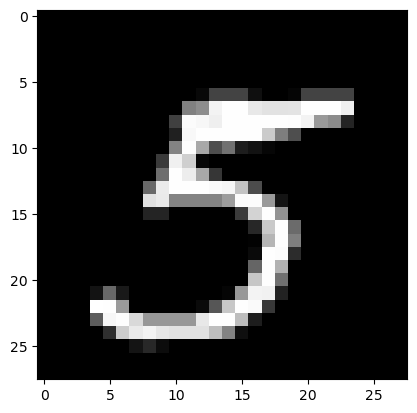

Prediction:  [6]
Label:  6


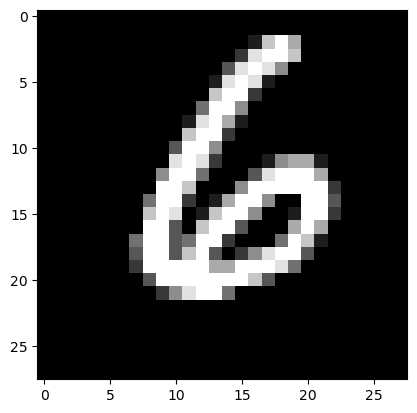

Prediction:  [6]
Label:  7


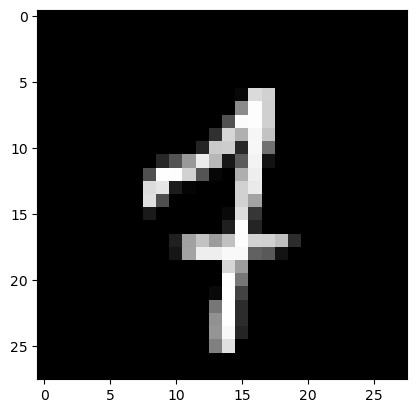

Prediction:  [6]
Label:  6


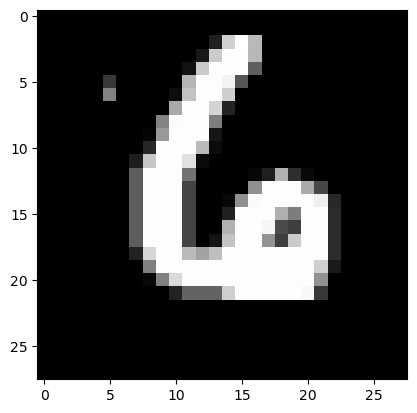

In [5]:
def init_params():
    W1=np.random.randn(10,784)     #((784, 10) * np.sqrt(2.0 / 784)) #sqrt standardization for layer with ReLU activation
    B1=np.random.randn(10,1)
    W2=np.random.randn(10,10)                #((10, 10) * np.sqrt(1.0 / 10)) #Xavier / glorot standardization for layer with Sigmoid activation
    B2=np.random.randn(10,1)
    return W1, B1, W2, B2


def forward_propagation(W1, B1, W2, B2, X):
    Z1= W1.dot(X) + B1
    A1= ReLU(Z1)
    Z2 = W2.dot(A1) +B2
    #print(Z2.shape)
    A2= softmax(Z2)
    return Z1, A1, Z2, A2


def one_hot(Y):
    one_hot_Y = np.zeros((Y.max()+1,Y.size)) #returns a 0 vector with 1 only in the position corresponding to the value in Y
    one_hot_Y[Y,np.arange(Y.size)] = 1
    return one_hot_Y


#my understanding of the math:
# cost function: 1/m * (A2-ohY)^2
#dc/dw1= dc/da2 * da2/dz2 * dz2/dw2 * dw2/da1 * da1/dz1 * dz1/dw1
#dc/db1= dc/da2 * da2/dz2 * dz2/db2 * db2/da1 * da1/dz1 * dz1/db1


def backward_propagation(X, Y, A1, A2, W2, Z1, m):
    
    one_hot_Y = one_hot(Y)
    dZ2 = 2*(A2 - one_hot_Y) #10,m
    dW2 = 1/m * (dZ2.dot(A1.T)) # 10 , 10
    db2 = 1/m * np.sum(dZ2,1) # 10, 1
    
    dZ1 = W2.T.dot(dZ2)*derivative_ReLU(Z1) # 10, m
    dW1 = 1/m * (dZ1.dot(X.T)) #10, 784
    db1 = 1/m * np.sum(dZ1,1) # 10, 1
    
    return dW2, db2, dW1, db1



def update_params(W1, W2, B1, B2, dW2, db2, dW1, db1, alpha):
    W1-= alpha * dW1
    W2-= alpha * dW2
    B1-= alpha * np.reshape(db1, (10,1))
    B2-= alpha * np.reshape(db2, (10,1))

    return W1, W2, B1, B2

def predictions(A2):
    return np.argmax(A2,0)

def accuracy(predictions, Y):
    return (np.sum(predictions==Y)/Y.size)

def grad_descent(X,Y, alpha, epoch):
    size , m = X.shape
    W1, B1, W2, B2= init_params()
    for i in range(epoch):
        Z1, A1, Z2, A2=forward_propagation(W1, B1, W2, B2, X)
        dW2, db2, dW1, db1= backward_propagation(X, Y, A1, A2, W2, Z1, m)
        W1, W2, B1, B2= update_params(W1, W2, B1, B2, dW2, db2, dW1, db1, alpha)

        if i%100==0:
            print(f"{i} , {epoch}")
            pred= predictions(A2)
            acc= accuracy(pred, Y)
            print(f"accuracy: {acc}")

    return W1, W2, B1, B2

W1, W2, B1, B2 = grad_descent(X_train, Y_train, 0.15, 1000)

def make_predictions(X, W1, B1, W2, B2):
    Z1, A1, Z2, A2 = forward_propagation(W1, B1, W2, B2, X)
    prediction = predictions(A2)
    return prediction

def test_prediction(index, W1, B1, W2, B2):
    current_image = X_train[:, index, None]
    predict = make_predictions(X_train[:, index, None], W1, B1, W2, B2)
    label = Y_train[index]
    print("Prediction: ", predict)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
test_prediction(0, W1, B1, W2, B2)
test_prediction(1, W1, B1, W2, B2)
test_prediction(2, W1, B1, W2, B2)
test_prediction(3, W1, B1, W2, B2)
